In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    # opt = Adam(learning_rate = 0.000001)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()
    
    return model

In [3]:
from keras.utils.np_utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [4]:
!unzip -u "/content/drive/MyDrive/datasets/patches.zip" -d "/content/drive/MyDrive/datasets"

Archive:  /content/drive/MyDrive/datasets/patches.zip
   creating: /content/drive/MyDrive/datasets/patches/images/
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_00.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_01.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_02.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_03.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_04.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_05.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_06.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_07.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_10.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_11.tif  
  inflating: /content/drive/MyDrive/datasets/patches/images/image__0_12.tif  
  inflating: /content/drive

In [5]:
image_directory = '/content/drive/MyDrive/datasets/patches/images/'
mask_directory = '/content/drive/MyDrive/datasets/patches/masks/'


SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [6]:
images = os.listdir(image_directory)
images.sort()
# print(images)

In [7]:
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        # print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))
print("number of images:\n",i)

number of images:
 959


In [8]:
masks = os.listdir(mask_directory)
masks.sort()
# print(masks)

In [9]:
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        # print(mask_directory+image_name)
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))
print("number of masks:\n",i)

number of masks:
 959


**make sure number of images and masks are same**

In [10]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

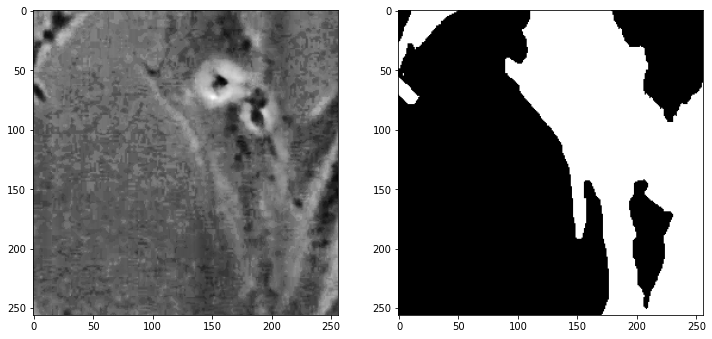

In [16]:
#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [17]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

In [18]:
#If starting with pre-trained weights. 
#model.load_weights('/content/drive/MyDrive/datasets/fibroblast.hdf5')

history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('/content/drive/MyDrive/datasets/fibroblast.hdf5')

Epoch 1/25
54/54 [==============================] - 39s 443ms/step - loss: 0.4262 - accuracy: 0.8604 - val_loss: 0.4170 - val_accuracy: 0.8565
Epoch 2/25
54/54 [==============================] - 23s 436ms/step - loss: 0.3874 - accuracy: 0.8726 - val_loss: 0.4053 - val_accuracy: 0.8565
Epoch 3/25
54/54 [==============================] - 23s 434ms/step - loss: 0.3824 - accuracy: 0.8726 - val_loss: 0.4017 - val_accuracy: 0.8565
Epoch 4/25
54/54 [==============================] - 23s 422ms/step - loss: 0.3755 - accuracy: 0.8726 - val_loss: 0.3641 - val_accuracy: 0.8611
Epoch 5/25
54/54 [==============================] - 23s 421ms/step - loss: 0.3827 - accuracy: 0.8733 - val_loss: 0.3971 - val_accuracy: 0.8565
Epoch 6/25
54/54 [==============================] - 23s 423ms/step - loss: 0.3714 - accuracy: 0.8726 - val_loss: 0.3899 - val_accuracy: 0.8565
Epoch 7/25
54/54 [==============================] - 23s 421ms/step - loss: 0.3675 - accuracy: 0.8733 - val_loss: 0.3767 - val_accuracy: 0.8650

In [19]:
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


3/3 [==============================] - 5s 247ms/step - loss: 0.1508 - accuracy: 0.9424
Accuracy =  94.24436688423157 %


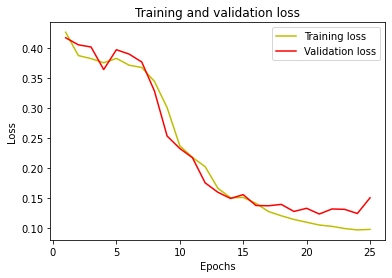

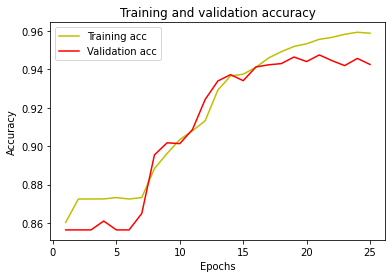

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/datasets/graph1.jpg')
plt.show()

# acc = history.history['acc']
acc = history.history['accuracy']
# val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/datasets/graph2.jpg')
plt.show()

In [21]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6411983801495994


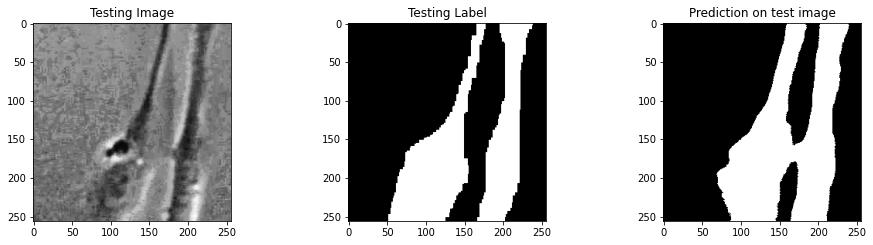

In [42]:
#Predict on a few images
model = get_model()
model.load_weights('/content/drive/MyDrive/datasets/fibroblast.hdf5')

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')